In [17]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [18]:
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

In [19]:
data_path = ''

train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
test = pd.read_csv(data_path + 'test.csv')


# item_categories = pd.read_csv(data_path + 'item_categories.csv')
# submission = pd.read_csv(data_path + 'sample_submission.csv')
print(train['date'].dtype)
train.head()

object


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [20]:
# Convert the date column to the datetime dtype to enable datetime operations.

train['date']=pd.to_datetime(train['date'], format = '%d.%m.%Y')

In [21]:
print(train['date'].dtype)
train.head()

datetime64[ns]


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [22]:
# Merge some duplicate shops
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
# Keep only shops that are in the test set
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]
# Drop training items with extreme or negative prices or sales counts
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

In [23]:
# # 이상치 제거와 동일
# # sales_train 데이터에서 상점ID 수정
# sales_train.loc[sales_train['상점ID'] == 0, '상점ID'] = 57
# sales_train.loc[sales_train['상점ID'] == 1, '상점ID'] = 58
# sales_train.loc[sales_train['상점ID'] == 10, '상점ID'] = 11
# sales_train.loc[sales_train['상점ID'] == 39, '상점ID'] = 40

# # 판매가가 0보다 큰 데이터 추출
# sales_train = sales_train[sales_train['판매가'] > 0]
# # 판매가가 50,000보다 작은 데이터 추출
# sales_train = sales_train[sales_train['판매가'] < 50000]

# # 판매량이 0보다 큰 데이터 추출
# sales_train = sales_train[sales_train['판매량'] > 0]
# # 판매량이 1,000보다 작은 데이터 추출
# sales_train = sales_train[sales_train['판매량'] < 1000]

In [24]:
def create_testlike_train(sales_train, test=None):
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],
    )

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")

        df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

In [25]:
# Performance_improve 비슷
# 월간 판매량, 평균 판매가
# 데이터 합치기
# 테스트 데이터 붙이기
matrix = create_testlike_train(train, test)
del(test)
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


In [26]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_revenue_day
0,2013-01-02,0,59,22154,999.00,1.0,999.00
1,2013-01-03,0,25,2552,899.00,1.0,899.00
3,2013-01-06,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00
5,2013-01-10,0,25,2564,349.00,1.0,349.00


In [27]:
# 다운캐스팅...
matrix = reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 405.44 MB
Memory usage after optimization is: 152.04 MB
Decreased by 62.5%


In [29]:
# items.query("item_id>3564").head(5)
items[items["item_id"]>3564].head(5)

,item_name,item_id,item_category_id
3565,"Fuse [PS3, английская версия]",3565,19
3566,"Fuse [Xbox 360, английская версия]",3566,23
3567,G Data Internet Security 2013 (1ПК / 1 год) (G...,3567,76
3568,G Data Internet Security 2013 (3ПК / 1 год) (G...,3568,76
3569,GABIN The Best Of Gabin 2CD,3569,55


In [30]:
# Item name grouping with fuzzywuzzy
## 두 문자열의 유사성 확인

In [35]:
import re

from fuzzywuzzy import fuzz


def add_item_name_groups(matrix, train, items, sim_thresh, feature_name="item_name_group"):
    def partialmatchgroups(items, sim_thresh=sim_thresh):
        def strip_brackets(string):
            string = re.sub(r"\(.*?\)", "", string)
            string = re.sub(r"\[.*?\]", "", string)
            return string

        items = items.copy()
        items["nc"] = items.item_name.apply(strip_brackets)
        items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

        def partialcompare(s):
            return fuzz.partial_ratio(s["nc"], s["ncnext"])

        items["partialmatch"] = items.apply(partialcompare, axis=1)
        # Assign groups
        grp = 0
        for i in range(items.shape[0]):
            items.loc[i, "partialmatchgroup"] = grp
            if items.loc[i, "partialmatch"] < sim_thresh:
                grp += 1
        items = items.drop(columns=["nc", "ncnext", "partialmatch"])
        return items

    items = partialmatchgroups(items)
    items = items.rename(columns={"partialmatchgroup": feature_name})
    items = items.drop(columns="partialmatchgroup", errors="ignore")

    items[feature_name] = items[feature_name].apply(str)
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left")
    train = train.merge(items[["item_id", feature_name]], on="item_id", how="left")
    return matrix, train


matrix, train = add_item_name_groups(matrix, train, items, 65)

In [32]:
# pip install fuzzywuzzy
# pip install fuzzywuzzy[speedup]
# pip install python-Levenshtein

Note: you may need to restart the kernel to use updated packages.


In [36]:
from fuzzywuzzy import fuzz
fuzz.ratio("Hello Python", "Hello Pytho")

96

In [37]:
import Levenshtein
Levenshtein.distance("Hello Python", "Hello Pytho")

1

In [38]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group
0,0,59,22154,1,999.0,9401
1,0,59,2552,0,0.0,1021
2,0,59,2554,0,0.0,1022
3,0,59,2555,0,0.0,1023
4,0,59,2564,0,0.0,1028
...,...,...,...,...,...,...
8856956,34,45,18454,0,0.0,7874
8856957,34,45,16188,0,0.0,6836
8856958,34,45,15757,0,0.0,6706
8856959,34,45,19648,0,0.0,8422


In [39]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_revenue_day,item_name_group
0,2013-01-02,0,59,22154,999.00,1.0,999.00,9401
1,2013-01-03,0,25,2552,899.00,1.0,899.00,1021
2,2013-01-06,0,25,2554,1709.05,1.0,1709.05,1022
3,2013-01-15,0,25,2555,1099.00,1.0,1099.00,1023
4,2013-01-10,0,25,2564,349.00,1.0,349.00,1028
...,...,...,...,...,...,...,...,...
2427349,2015-10-10,33,25,7409,299.00,1.0,299.00,2989
2427350,2015-10-09,33,25,7460,299.00,1.0,299.00,3023
2427351,2015-10-14,33,25,7459,349.00,1.0,349.00,3022
2427352,2015-10-22,33,25,7440,299.00,1.0,299.00,3009


In [46]:
# Music Artist / first word of item name
# 유의미한 단어 토큰만을 선별하기 위해서는 큰 의미가 없는 단어 토큰을 제거 필요
# I, my, me, 조사, 접미사 같은 단어들은 문장에서 자주 등장하지만 실제 의미 분석에 있어서는 기여하는 바가
# 적어, 이를 불용어(stopword)라고 하며, NLTK에서는 위와 같은 100여개 이상의 영어단어들을 불용어로
# 패키지로 제공

In [48]:
# 아티스트 이름에 따라 음악 항목을 그룹으로 할당
# 음악 항목이 아닌 경우 첫 번째 단어에 따라 항목이 그룹화

In [44]:
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

def add_first_word_features(matrix, items=items, feature_name="artist_name_or_first_word"):
    # This extracts artist names for music categories and adds them as a feature.
    def extract_artist(st):
        st = st.strip()
        if st.startswith("V/A"):
            artist = "V/A"
        elif st.startswith("СБ"):
            artist = "СБ"
        else:
            # Retrieves artist names using the double space or all uppercase pattern
            mus_artist_dubspace = re.compile(r".{2,}?(?=\s{2,})")
            match_dubspace = mus_artist_dubspace.match(st)
            mus_artist_capsonly = re.compile(r"^([^a-zа-я]+\s)+")
            match_capsonly = mus_artist_capsonly.match(st)
            candidates = [match_dubspace, match_capsonly]
            candidates = [m[0] for m in candidates if m is not None]
            # Sometimes one of the patterns catches some extra words so choose the shortest one
            if len(candidates):
                artist = min(candidates, key=len)
            else:
                # If neither of the previous patterns found something, use the dot-space pattern
                mus_artist_dotspace = re.compile(r".{2,}?(?=\.\s)")
                match = mus_artist_dotspace.match(st)
                if match:
                    artist = match[0]
                else:
                    artist = ""
        artist = artist.upper()
        artist = re.sub(r"[^A-ZА-Я ]||\bTHE\b", "", artist)
        artist = re.sub(r"\s{2,}", " ", artist)
        artist = artist.strip()
        return artist

    items = items.copy()
    all_stopwords = stopwords.words("russian")
    all_stopwords = all_stopwords + stopwords.words("english")

    def first_word(string):
        # This cleans the string of special characters, excess spaces and stopwords then extracts the first word
        string = re.sub(r"[^\w\s]", "", string)
        string = re.sub(r"\s{2,}", " ", string)
        tokens = string.lower().split()
        tokens = [t for t in tokens if t not in all_stopwords]
        token = tokens[0] if len(tokens) > 0 else ""
        return token

    music_categories = [55, 56, 57, 58, 59, 60]
    items.loc[items.item_category_id.isin(music_categories), feature_name] = items.loc[
        items.item_category_id.isin(music_categories), "item_name"
    ].apply(extract_artist)
    items.loc[items[feature_name] == "", feature_name] = "other music"
    items.loc[~items.item_category_id.isin(music_categories), feature_name] = items.loc[
        ~items.item_category_id.isin(music_categories), "item_name"
    ].apply(first_word)
    items.loc[items[feature_name] == "", feature_name] = "other non-music"
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left",)
    return matrix


matrix = add_first_word_features(
    matrix, items=items, feature_name="artist_name_or_first_word"
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [45]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group,artist_name_or_first_word
0,0,59,22154,1,999.0,9401,4950
1,0,59,2552,0,0.0,1021,384
2,0,59,2554,0,0.0,1022,384
3,0,59,2555,0,0.0,1023,384
4,0,59,2564,0,0.0,1028,384
...,...,...,...,...,...,...,...
8856956,34,45,18454,0,0.0,7874,4108
8856957,34,45,16188,0,0.0,6836,3467
8856958,34,45,15757,0,0.0,6706,3427
8856959,34,45,19648,0,0.0,8422,4451


In [49]:
# Item name length as a feature
# 유사한 아이템들이 비슷한 길이의 이름 가지기 때문에 prediction하는데 예측력이 좋다.
# 특수 문자 형태와 출시 형식 등은 유사성이 불분명하게 하기에 제거

In [50]:
import re
def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"\[.*?\]", "", string)
    string = re.sub(r"\(.*?\)", "", string)
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items["item_name_length"] = items["item_name"].apply(len)
matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')
items = items.drop(columns=['item_name_length', 'item_name_cleaned_length'])

In [51]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [52]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group,artist_name_or_first_word,item_name_length,item_name_cleaned_length
0,0,59,22154,1,999.0,9401,4950,17,13
1,0,59,2552,0,0.0,1021,384,40,38
2,0,59,2554,0,0.0,1022,384,40,38
3,0,59,2555,0,0.0,1023,384,39,32
4,0,59,2564,0,0.0,1028,384,50,43
...,...,...,...,...,...,...,...,...,...
8856956,34,45,18454,0,0.0,7874,4108,11,10
8856957,34,45,16188,0,0.0,6836,3467,28,27
8856958,34,45,15757,0,0.0,6706,3427,34,33
8856959,34,45,19648,0,0.0,8422,4451,31,19


In [53]:
print("Created name features")
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

Created name features


In [55]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group,artist_name_or_first_word,item_name_length,item_name_cleaned_length
0,0,59,22154,1,999.0,9401,4950,17,13
1,0,59,2552,0,0.0,1021,384,40,38
2,0,59,2554,0,0.0,1022,384,40,38
3,0,59,2555,0,0.0,1023,384,39,32
4,0,59,2564,0,0.0,1028,384,50,43


# Time 피쳐

In [57]:
def add_time_features(m, train, correct_item_cnt_day=False):
    from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

    def item_shop_age_months(m):
        m["item_age"] = m.groupby("item_id")["date_block_num"].transform(
            lambda x: x - x.min()
        )
        # Sales tend to plateau after 12 months
        m["new_item"] = m["item_age"] == 0
        m["new_item"] = m["new_item"].astype("int8")
        m["shop_age"] = (
            m.groupby("shop_id")["date_block_num"]
            .transform(lambda x: x - x.min())
            .astype("int8")
        )
        return m

    # Add dummy values for the test month so that features are created correctly
    dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    dummies = dummies.assign(
        date=pd.to_datetime("2015-11-30"), item_price=1, item_cnt_day=0, item_revenue_day=0,
    )
    train = pd.concat([train, dummies])
    del dummies

    month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
    month_last_day[~month_last_day.dt.is_month_end] = (
        month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
    )
    month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
    month_first_day[~month_first_day.dt.is_month_start] = (
        month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
    )
    month_length = (month_last_day - month_first_day + Day()).rename("month_length")
    first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
    first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
    first_shop_item_date = (
        train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
    )
    first_item_name_group_date = (
        train.groupby("item_name_group").date.min().rename("first_name_group_date")
    )

    m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
    m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
    m = m.merge(
        first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left"
    )
    m = m.merge(
        first_item_name_group_date, left_on="item_name_group", right_index=True, how="left"
    )

    # Calculate how long the item was sold for in each month and use this to calculate average sales per day
    m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
    m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
    m["item_in_shop_days"] = (
        m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
    )
    m = m.drop(columns="item_first_sale_days")
    m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]
    m["month_length"] = m["month_length"].dt.days

    # Calculate the time differences from the beginning of the month so they can be used as features without lagging
    m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
    m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
    m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
    m["first_name_group_sale_days"] = m["month_first_day"] - m["first_name_group_date"]
    m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)
    m["first_item_sale_days"] = (
        m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_shop_item_sale_days"] = (
        m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_name_group_sale_days"] = (
        m["first_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )

    # Add days since last sale
    def last_sale_days(matrix):
        last_shop_item_dates = []
        for dbn in range(1, 35):
            lsid_temp = (
                train.query(f"date_block_num<{dbn}")
                .groupby(["shop_id", "item_id"])
                .date.max()
                .rename("last_shop_item_sale_date")
                .reset_index()
            )
            lsid_temp["date_block_num"] = dbn
            last_shop_item_dates.append(lsid_temp)

        last_shop_item_dates = pd.concat(last_shop_item_dates)
        matrix = matrix.merge(
            last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
        )

        def days_since_last_feat(m, feat_name, date_feat_name, missingval):
            m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
            m.loc[m[feat_name] > 2000, feat_name] = missingval
            m.loc[m[feat_name].isna(), feat_name] = missingval
            return m

        matrix = days_since_last_feat(
            matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999
        )

        matrix = matrix.drop(columns=["last_shop_item_sale_date"])
        return matrix

    m = last_sale_days(m)
    # Month id feature
    m["month"] = m["month_first_day"].dt.month

    m = m.drop(
        columns=[
            "first_day",
            "month_first_day",
            "month_last_day",
            "first_shop_date",
            "first_item_date",
            "first_name_group_date",
            "item_in_shop_days",
            "first_shop_item_date",
            "month_length",
        ],
        errors="ignore",
    )

    m = item_shop_age_months(m)

    if correct_item_cnt_day == True:
        m["item_cnt_month_original"] = m["item_cnt_month"]
        m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]

    return m

In [58]:
matrix = add_time_features(matrix, train, False)
print("Time features created")

Time features created


In [59]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group,artist_name_or_first_word,item_name_length,item_name_cleaned_length,shop_open_days,item_cnt_day_avg,first_item_sale_days,first_shop_item_sale_days,first_name_group_sale_days,last_shop_item_sale_days,month,item_age,new_item,shop_age
0,0,59,22154,1,999.0,9401,4950,17,13,0,0.033333,9999,9999.0,9999.0,9999.0,1,0,1,0
1,0,59,2552,0,0.0,1021,384,40,38,0,0.000000,9999,9999.0,9999.0,9999.0,1,0,1,0
2,0,59,2554,0,0.0,1022,384,40,38,0,0.000000,9999,9999.0,9999.0,9999.0,1,0,1,0
3,0,59,2555,0,0.0,1023,384,39,32,0,0.000000,9999,9999.0,9999.0,9999.0,1,0,1,0
4,0,59,2564,0,0.0,1028,384,50,43,0,0.000000,9999,9999.0,9999.0,9999.0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856956,34,45,18454,0,0.0,7874,4108,11,10,1033,0.000000,323,320.0,1034.0,2.0,11,11,0,34
8856957,34,45,16188,0,0.0,6836,3467,28,27,1033,0.000000,51,9999.0,1033.0,9999.0,11,2,0,34
8856958,34,45,15757,0,0.0,6706,3427,34,33,1033,0.000000,1033,1010.0,1033.0,252.0,11,34,0,34
8856959,34,45,19648,0,0.0,8422,4451,31,19,1033,0.000000,325,9999.0,325.0,9999.0,11,11,0,34


# Item Category feature

In [61]:
matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

platform_map = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 1, 11: 2,
    12: 3, 13: 4, 14: 5, 15: 6, 16: 7, 17: 8, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5,
    23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 11,
    34: 11, 35: 3, 36: 0, 37: 12, 38: 12, 39: 12, 40: 13, 41: 13, 42: 14, 43: 15,
    44: 15, 45: 15, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14,
    54: 8, 55: 16, 56: 16, 57: 17, 58: 18, 59: 13, 60: 16, 61: 8, 62: 8, 63: 8, 64: 8,
    65: 8, 66: 8, 67: 8, 68: 8, 69: 8, 70: 8, 71: 8, 72: 8, 73: 0, 74: 10, 75: 0,
    76: 0, 77: 0, 78: 0, 79: 8, 80: 8, 81: 8, 82: 8, 83: 8,
}
matrix['platform_id'] = matrix['item_category_id'].map(platform_map)

supercat_map = {
    0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 1,
    13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3,
    24: 3, 25: 0, 26: 2, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2,
    35: 2, 36: 2, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5,
    46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 6, 56: 6,
    57: 6, 58: 6, 59: 6, 60: 6, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0,
    68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7,
    79: 2, 80: 2, 81: 0, 82: 0, 83: 0
}
matrix['supercategory_id'] = matrix['item_category_id'].map(supercat_map)

In [62]:
# two additional category groupings - supercategory (e.g. "games", "music") and platform (e.g. "PS4", "mp3").

In [63]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group,artist_name_or_first_word,item_name_length,item_name_cleaned_length,shop_open_days,...,first_shop_item_sale_days,first_name_group_sale_days,last_shop_item_sale_days,month,item_age,new_item,shop_age,item_category_id,platform_id,supercategory_id
0,0,59,22154,1,999.0,9401,4950,17,13,0,...,9999.0,9999.0,9999.0,1,0,1,0,37,12,4
1,0,59,2552,0,0.0,1021,384,40,38,0,...,9999.0,9999.0,9999.0,1,0,1,0,58,18,6
2,0,59,2554,0,0.0,1022,384,40,38,0,...,9999.0,9999.0,9999.0,1,0,1,0,58,18,6
3,0,59,2555,0,0.0,1023,384,39,32,0,...,9999.0,9999.0,9999.0,1,0,1,0,56,16,6
4,0,59,2564,0,0.0,1028,384,50,43,0,...,9999.0,9999.0,9999.0,1,0,1,0,59,13,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856956,34,45,18454,0,0.0,7874,4108,11,10,1033,...,320.0,1034.0,2.0,11,11,0,34,55,16,6
8856957,34,45,16188,0,0.0,6836,3467,28,27,1033,...,9999.0,1033.0,9999.0,11,2,0,34,64,8,0
8856958,34,45,15757,0,0.0,6706,3427,34,33,1033,...,1010.0,1033.0,252.0,11,34,0,34,55,16,6
8856959,34,45,19648,0,0.0,8422,4451,31,19,1033,...,9999.0,325.0,9999.0,11,11,0,34,40,13,4


# shop city

In [65]:
# from https://www.kaggle.com/dlarionov/feature-engineering-xgboost

In [66]:
def add_city_codes(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0]
    shop_labels = shops[["shop_id", "city_code"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_city_codes(matrix, shops)
del(shops)

In [67]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group,artist_name_or_first_word,item_name_length,item_name_cleaned_length,shop_open_days,...,first_name_group_sale_days,last_shop_item_sale_days,month,item_age,new_item,shop_age,item_category_id,platform_id,supercategory_id,city_code
0,0,59,22154,1,999.0,9401,4950,17,13,0,...,9999.0,9999.0,1,0,1,0,37,12,4,30
1,0,59,2552,0,0.0,1021,384,40,38,0,...,9999.0,9999.0,1,0,1,0,58,18,6,30
2,0,59,2554,0,0.0,1022,384,40,38,0,...,9999.0,9999.0,1,0,1,0,58,18,6,30
3,0,59,2555,0,0.0,1023,384,39,32,0,...,9999.0,9999.0,1,0,1,0,56,16,6,30
4,0,59,2564,0,0.0,1028,384,50,43,0,...,9999.0,9999.0,1,0,1,0,59,13,6,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856956,34,45,18454,0,0.0,7874,4108,11,10,1033,...,1034.0,2.0,11,11,0,34,55,16,6,21
8856957,34,45,16188,0,0.0,6836,3467,28,27,1033,...,1033.0,9999.0,11,2,0,34,64,8,0,21
8856958,34,45,15757,0,0.0,6706,3427,34,33,1033,...,1033.0,252.0,11,34,0,34,55,16,6,21
8856959,34,45,19648,0,0.0,8422,4451,31,19,1033,...,325.0,9999.0,11,11,0,34,40,13,4,21


# Shop and item category clustering

In [ ]:
# 상점과 아이템 카테고리의 주성분 분석 분해 및 클러스터링 결과를 수행하고 시각화

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 20
    end_month = 32
    pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

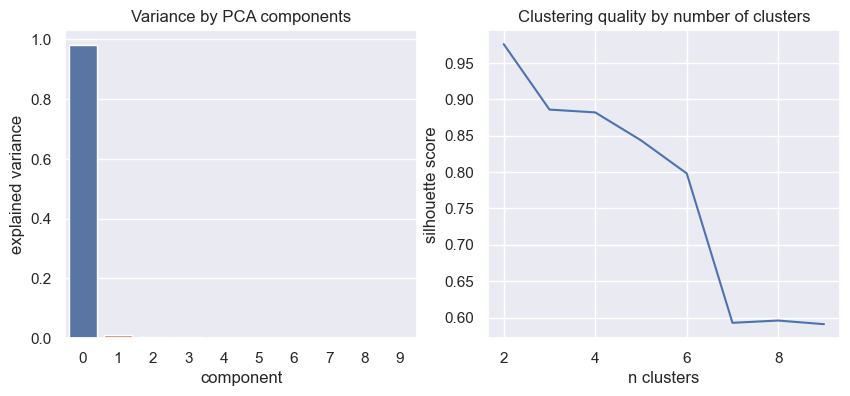

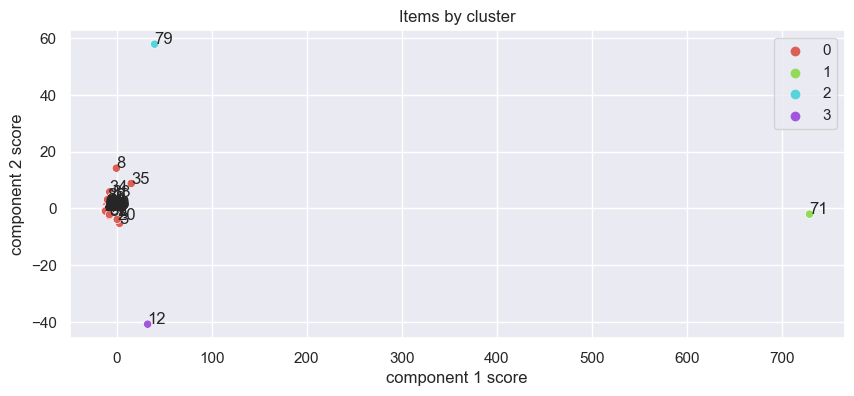

In [70]:
category_group_dict = cluster_feature(matrix, 'item_cnt_month', 'item_category_id', 'date_block_num', n_components=2, n_clusters=4, aggfunc="mean", exclude =[])
matrix['category_cluster'] = matrix['item_category_id'].map(category_group_dict)

In [ ]:
# 아이템 카테고리는 매월 평균 판매량에 따라 군집화

In [71]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group,artist_name_or_first_word,item_name_length,item_name_cleaned_length,shop_open_days,...,last_shop_item_sale_days,month,item_age,new_item,shop_age,item_category_id,platform_id,supercategory_id,city_code,category_cluster
0,0,59,22154,1,999.0,9401,4950,17,13,0,...,9999.0,1,0,1,0,37,12,4,30,0
1,0,59,2552,0,0.0,1021,384,40,38,0,...,9999.0,1,0,1,0,58,18,6,30,0
2,0,59,2554,0,0.0,1022,384,40,38,0,...,9999.0,1,0,1,0,58,18,6,30,0
3,0,59,2555,0,0.0,1023,384,39,32,0,...,9999.0,1,0,1,0,56,16,6,30,0
4,0,59,2564,0,0.0,1028,384,50,43,0,...,9999.0,1,0,1,0,59,13,6,30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856956,34,45,18454,0,0.0,7874,4108,11,10,1033,...,2.0,11,11,0,34,55,16,6,21,0
8856957,34,45,16188,0,0.0,6836,3467,28,27,1033,...,9999.0,11,2,0,34,64,8,0,21,0
8856958,34,45,15757,0,0.0,6706,3427,34,33,1033,...,252.0,11,34,0,34,55,16,6,21,0
8856959,34,45,19648,0,0.0,8422,4451,31,19,1033,...,9999.0,11,11,0,34,40,13,4,21,0


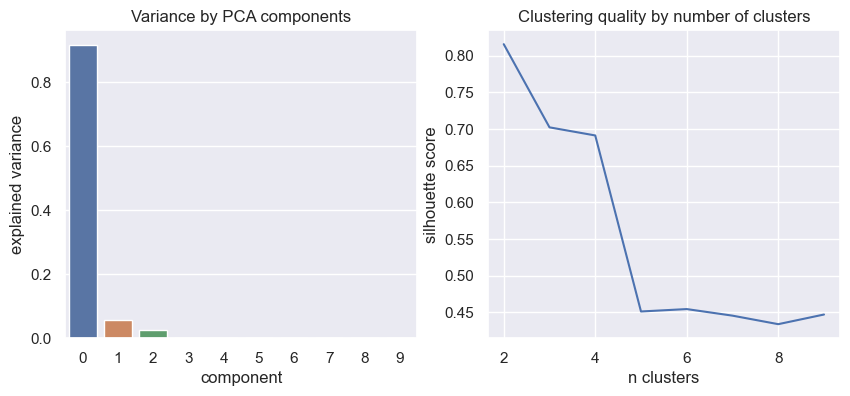

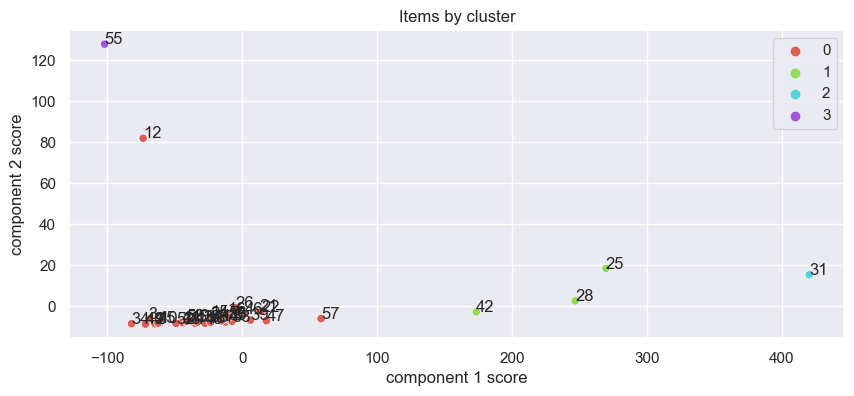

In [72]:
shop_group_dict = cluster_feature(matrix, 'item_cnt_month', 'shop_id', 'item_category_id', n_components=4, n_clusters=4, aggfunc="mean", exclude=[36])
shop_group_dict[36] = shop_group_dict[37]  # Shop36 added separately because it only has one month of data
matrix['shop_cluster'] = matrix['shop_id'].map(shop_group_dict)

In [ ]:
# shop은 item category의 총 판매액에 따라 군집화
# shop 31 매출 규모가 커 이상치

In [73]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group,artist_name_or_first_word,item_name_length,item_name_cleaned_length,shop_open_days,...,month,item_age,new_item,shop_age,item_category_id,platform_id,supercategory_id,city_code,category_cluster,shop_cluster
0,0,59,22154,1,999.0,9401,4950,17,13,0,...,1,0,1,0,37,12,4,30,0,0
1,0,59,2552,0,0.0,1021,384,40,38,0,...,1,0,1,0,58,18,6,30,0,0
2,0,59,2554,0,0.0,1022,384,40,38,0,...,1,0,1,0,58,18,6,30,0,0
3,0,59,2555,0,0.0,1023,384,39,32,0,...,1,0,1,0,56,16,6,30,0,0
4,0,59,2564,0,0.0,1028,384,50,43,0,...,1,0,1,0,59,13,6,30,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856956,34,45,18454,0,0.0,7874,4108,11,10,1033,...,11,11,0,34,55,16,6,21,0,0
8856957,34,45,16188,0,0.0,6836,3467,28,27,1033,...,11,2,0,34,64,8,0,21,0,0
8856958,34,45,15757,0,0.0,6706,3427,34,33,1033,...,11,34,0,34,55,16,6,21,0,0
8856959,34,45,19648,0,0.0,8422,4451,31,19,1033,...,11,11,0,34,40,13,4,21,0,0


In [74]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)  
# Use this function periodically to downcast dtypes to save memory

In [75]:
def uniques(matrix, groupers, name, limitation=None):
    if limitation is not None:
        s = (
            matrix.query(limitation)
            .groupby(groupers)
            .item_id.nunique()
            .rename(name)
            .reset_index()
        )
    else:
        s = matrix.groupby(groupers).item_id.nunique().rename(name).reset_index()
    matrix = matrix.merge(s, on=groupers, how="left")
    matrix[name] = matrix[name].fillna(0)
    return matrix


matrix = uniques(matrix, ["date_block_num"], "unique_items_month")

matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_unique_month")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_name_group"],
    "name_group_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(
    matrix, ["date_block_num", "artist_name_or_first_word"], "first_word_unique_month"
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "artist_name_or_first_word"],
    "first_word_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(matrix, ["date_block_num", "item_category_id"], "unique_items_cat")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id"],
    "new_items_cat",
    limitation="new_item==True",
)
matrix = uniques(matrix, ["date_block_num"], "new_items_month", limitation="new_item==True")

matrix["cat_items_proportion"] = matrix["unique_items_cat"] / matrix["unique_items_month"]
matrix["name_group_new_proportion_month"] = (
    matrix["name_group_new_unique_month"] / matrix["name_group_unique_month"]
)

matrix = matrix.drop(columns=["unique_items_month", "name_group_unique_month"])

In [76]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,item_revenue_month,item_name_group,artist_name_or_first_word,item_name_length,item_name_cleaned_length,shop_open_days,...,name_group_new_cat_unique_month,first_word_unique_month,first_word_cat_unique_month,first_word_new_unique_month,first_word_new_cat_unique_month,unique_items_cat,new_items_cat,new_items_month,cat_items_proportion,name_group_new_proportion_month
0,0,59,22154,1,999.0,9401,4950,17,13,0,...,1.0,2,1,2.0,1.0,620,620.0,7644,0.081109,1.0
1,0,59,2552,0,0.0,1021,384,40,38,0,...,1.0,23,8,23.0,8.0,132,132.0,7644,0.017268,1.0
2,0,59,2554,0,0.0,1022,384,40,38,0,...,1.0,23,8,23.0,8.0,132,132.0,7644,0.017268,1.0
3,0,59,2555,0,0.0,1023,384,39,32,0,...,2.0,23,3,23.0,3.0,87,87.0,7644,0.011381,1.0
4,0,59,2564,0,0.0,1028,384,50,43,0,...,1.0,23,4,23.0,4.0,151,151.0,7644,0.019754,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8856956,34,45,18454,0,0.0,7874,4108,11,10,1033,...,0.0,81,48,0.0,0.0,672,38.0,384,0.131765,0.0
8856957,34,45,16188,0,0.0,6836,3467,28,27,1033,...,0.0,159,110,9.0,7.0,128,11.0,384,0.025098,0.0
8856958,34,45,15757,0,0.0,6706,3427,34,33,1033,...,0.0,1,1,0.0,0.0,672,38.0,384,0.131765,0.0
8856959,34,45,19648,0,0.0,8422,4451,31,19,1033,...,0.0,1,1,0.0,0.0,770,71.0,384,0.150980,0.0


In [77]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

In [78]:
#https://www.kaggle.com/code/deinforcement/top-1-predict-future-sales-features-lightgbm

In [ ]:
#https://www.kaggle.com/code/abubakar624/first-place-solution-kaggle-predict-future-sales